In [172]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk

In [173]:
direction_path = "Training"
folders_names = sorted(os.listdir(direction_path))
print(folders_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [178]:
def preprocess_mri(files_paths):
    # Load the image using OpenCV
    image = cv2.imread(files_paths, cv2.IMREAD_GRAYSCALE)

    # Intensity normalization
    normalized_image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

    # Apply a Gaussian smoothing filter with a sigma of 2mm
    smoothed_image = cv2.GaussianBlur(normalized_image, (0, 0), 2)
    
    new_file_path = files_paths.replace("Training", "PreProcessedTraining")

    # Write the preprocessed image to disk
    cv2.imwrite(new_file_path, image)


In [179]:
# Define a function to load and preprocess the images
def load_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    img = cv2.resize(img, (256, 256))  # Resize to a fixed size
    img = img.flatten()  # Flatten the image into a 1D array
    return img

In [180]:
def get_filesList(folders_names,direction_path):
    files_paths,labels =[],[]
    # Load and preprocess the image data
    X = []
    y = []
    for folder in folders_names:
        class_path = os.path.join(direction_path, folder)
        file_list = sorted(os.listdir(class_path))
        for file in file_list:
            file_path= os.path.join(class_path, file)
            preprocess_mri(file_path)
            new_file_path = file_path.replace("Training", "PreProcessedTraining")
            X.append(load_image(new_file_path))
            y.append(folder)

            files_paths.append(new_file_path)
            labels.append(folder)

    return files_paths,labels,X,y

PRE-PROCESS DATA

In [182]:

files_paths,labels,X,y= get_filesList(folders_names,direction_path)


Visualization after processing

Text(0.5, 1.0, 'Pre-Processed')

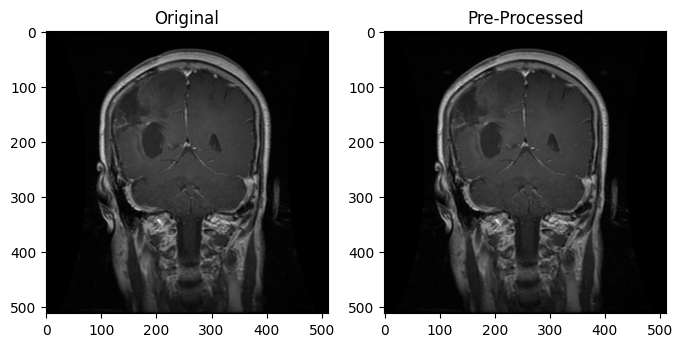

In [152]:
import matplotlib.image as mpimg

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))
original = mpimg.imread("Training/glioma/Tr-gl_0010.jpg")
after_pre_processing=mpimg.imread("PreProcessedTraining/glioma/Tr-gl_0010.jpg")
# Show the images on the subplots
ax1.imshow(original)
ax2.imshow(after_pre_processing, cmap='gray')
# Add titles to the subplots
ax1.set_title('Original')
ax2.set_title('Pre-Processed')

FEATURE EXTRACTION


In [167]:
from skimage.feature.texture  import graycomatrix, graycoprops

contrast=[]
homogeneity=[]
energy=[]
correlation=[]

features = pd.DataFrame({
    'contrast': [],
    'homogeneity': [],
    'energy': [],
    'correlation': []
})

for image in X:
    
    image = np.reshape(image, (256, 256))
    glcm = graycomatrix(image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)

    # Compute some GLCM properties
    contrast.append(graycoprops(glcm, 'contrast')[0][0])
    homogeneity.append(graycoprops(glcm, 'homogeneity')[0][0])
    energy.append(graycoprops(glcm, 'energy')[0][0])
    correlation.append(graycoprops(glcm, 'correlation')[0][0])
    
   
features['contrast']=contrast
features['homogeneity']=homogeneity
features['energy']=energy
features['correlation']=correlation





In [168]:
print(features.size)

22848


In [128]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder


# Initialize the LabelEncoder
le = LabelEncoder()

# Fit the LabelEncoder to the names and transform the names to numbers
Y = le.fit_transform(y)



X_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)
RF = RandomForestClassifier(n_estimators=100, random_state=42)
RF.fit(X_train,y_train)
y_pred = RF.predict(x_test)
print("Accuracy",accuracy_score(y_test,y_pred))

Accuracy 0.9247594050743657


C:\Users\Hager\AppData\Local\Temp\ipykernel_16600\286659089.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('gnuplot')


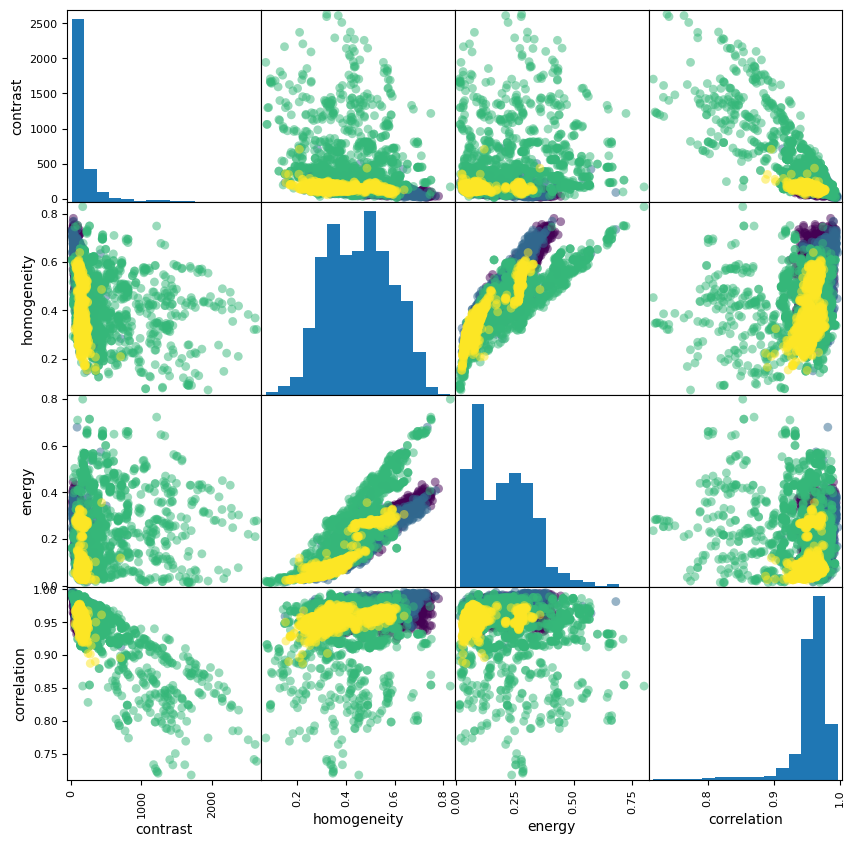

In [171]:
from matplotlib import cm

cmap = cm.get_cmap('gnuplot')
scatter = pd.plotting.scatter_matrix(features,c=Y, marker = 'o', s=40, hist_kwds={'bins':15}, figsize=(10,10))

In [ ]:
def obtain_dataframe(files_paths,labels):

    dataframe = pd.DataFrame({
        'image_path' : files_paths,
        'label' : labels
    })

    return dataframe

In [ ]:
df = obtain_dataframe(files_paths,labels)
print(df)

                             image_path      label
0      Training\glioma\Tr-glTr_0000.jpg     glioma
1      Training\glioma\Tr-glTr_0001.jpg     glioma
2      Training\glioma\Tr-glTr_0002.jpg     glioma
3      Training\glioma\Tr-glTr_0003.jpg     glioma
4      Training\glioma\Tr-glTr_0004.jpg     glioma
...                                 ...        ...
5707  Training\pituitary\Tr-pi_1452.jpg  pituitary
5708  Training\pituitary\Tr-pi_1453.jpg  pituitary
5709  Training\pituitary\Tr-pi_1454.jpg  pituitary
5710  Training\pituitary\Tr-pi_1455.jpg  pituitary
5711  Training\pituitary\Tr-pi_1456.jpg  pituitary

[5712 rows x 2 columns]


In [ ]:
number_classes = len(df['label'].unique())
print(f"we have {number_classes} classes")
print(f"we have {df.shape[0]} images")

we have 4 classes
we have 5712 images


In [ ]:
df['label'].value_counts()

label
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64